<h3> Q1 : Word Embeddings </h3>

In [131]:
import numpy as np
import csv
import itertools

<b>1.1 : Compute Xij </b>

In [38]:
######################### READ CSV FILE MOVIERATINGS AND GET THE DATA IN APPROPRIATE FORMAT ###################
f = open('movieratings.csv')
csv_f = csv.reader(f)

parsed = (
           (int(row[0]),
           int(row[1]),
           int(row[2]))
          for row in csv_f)

movierating = []

for row in parsed:
    movierating.append(row)

In [39]:
################## WE NEED ONLY THE MOVIES WHICH HAVE LIKES #######################################
movierating_likes = [item for item in movierating if item[2] == 1]

In [41]:
#### CONVERT movierating_likes INTO NUMPY ARRAY FOR FURTHER PROCESSING ###########################
movierating_ar = np.array(movierating_likes)


In [43]:
############### get all possible combinations of movies from 1..1682. ######################################
############### This is used to calculate the gradient descent over each possible pair.########################
no_movies = np.arange(1682)+1
#print(no_movies)
allmovies = list(itertools.combinations(no_movies,2))


In [44]:
############### get the list of unique user IDs #################################################
unique_people = np.unique(movierating_ar[:,1])

In [9]:
### test. Note that one user ID is missing
print(len(unique_people))

942


<b>Calculate Xij for each reviewer</b>

In [177]:

######## Initialize a 2D array for Xij. 
######## The shape of Xij is taken as (1683,1683) so that movie ids from 1-1682 can directly be mapped 
######## to the respective index of matrix making later computations easier
Xij = np.zeros((1683,1683),dtype=np.float64) 
liked_combos=[]   ## empty list for keeping track of the movie combinations for wach user
liked_combos_dict = {}  ## distionary that maps each user to their liked movie combos
for reviewer in unique_people:  ## run a loop to get combinations for each user
    reviewed_movies = movierating_ar[movierating_ar[:,1]==reviewer]
    liked_combos = list(itertools.combinations(reviewed_movies[:,0],2))
    liked_combos_dict[reviewer]=liked_combos
    for (i,j) in liked_combos:
        Xij[i][j]+=1 ## increment the count in Xij symmetrically.
        Xij[j][i]+=1
        
                

In [194]:
####### Compute the cost function for each movie vector ##############
def computediff(vi,vj,xij):
    diff = (np.dot(vi,vj)-xij)
    #print(type(diff))
    return diff;



<b>1.2 Run Gradient Descent with initial values as vector of 0s and vector of random number between -0.7,0.7</b>

In [256]:
############# DEFINE VECTOR WITH RANDOM VALUES BETWEEN -0.7 AND +0.7. lENGTH 40 ############################
vivj_rand = np.random.uniform(-0.7,0.7,(1683,40))

In [386]:
################ Define vectors with values 0 ##########################################
vivj_zeros = np.zeros((1683,20))


In [215]:
################### Calculate Gradients for Gradient Descent ##############################

def find_gradients(vi_current,vj_current,xij):
    
    learning_rate = 0.0001;
    
    #np.seterr(all='print')
    vi_gradient = np.round(2*vj_current*computediff(vi_current,vj_current,xij),decimals=8)
    vj_gradient = np.round(2*vi_current*computediff(vi_current,vj_current,xij),decimals=8)
    #print("vigrad",vi_gradient)
    #print("vjgrad",vj_gradient)

    vi_current  = vi_current - np.round((learning_rate * vi_gradient),decimals=8)
    vj_current = vj_current - np.round((learning_rate * vj_gradient),decimals=8)
    
    return [vi_current,vj_current]

In [205]:
############ Compute total cost over all movie vectors as per cost function ########
def compute_total_cost(vec, d_mat):
    total_cost = 0;
    for i in range(1,1682):
        for j in range(i,1682):
            if(i!=j):
                cost = np.round(computediff(vec[i],vec[j],d_mat[i][j])**2)
                total_cost = total_cost+cost
    return total_cost
        

In [385]:
################## RUN GRADIENT DESCENT....
################# FOR VECTOR WITH INITIAL VALUES 0, RAN 100 ITERATIONS
################ FOR VECTOR WITH RANDOM VALUES, RAN 200 ITERATIONS. THE RESULTING VECTORS WERE USED FOR SIMILARITY CALCULATION
def run_gradient_descent(vec_init):
    
    #v_gradient= np.zeros((1683,20),dtype=np.float64)
    #vj_gradient=np.zeros((20,),dtype=np.float64)
    
    plot_cost = [] # list for storing costs and iteration no.
    iteration = 0; 
    #vec_init_new = np.zeros((1683,20),dtype=np.float64)
    vec_init_new = np.array(vec_init)
    while (iteration < 100):
        iteration+=1;
        cost_init = compute_total_cost(vec_init_new, Xij) #compute the total cost function for each vector
        #print(iteration,"::",cost_init)
        #print(vec_init_new[45,:])
        plot_cost.append((iteration,cost_init)) #append cost and iteration no. for plotting
        
        for movie_pair in allmovies:
            #find gradients and assign the newly calculated vectors to vec_init_new
            new_vi,new_vj = find_gradients(np.array(vec_init_new[movie_pair[0]]),np.array(vec_init_new[movie_pair[1]]),Xij[movie_pair[0]][movie_pair[1]])
            vec_init_new[movie_pair[0]]=new_vi
            vec_init_new[movie_pair[1]]=new_vj
        nan_found = np.isnan(vec_init_new)
        vec_init_new[nan_found]=0
        #print(vec_init_new)
    return [plot_cost,vec_init_new]
                    
        

In [ ]:
########### run gradient descent on vector having random value
cp,final_vector = run_gradient_descent(vivj_rand)
#print(cp)

In [ ]:
########## run gradient descent on vector having intial values as zero.

zero_cp,final_vector_zero = run_gradient_descent(vivj_zeros)

In [ ]:
############# JUST ASSIGNING ANOTHER VALUE SO THAT final_vector is not overwritten ################
vector_op = np.array(final_vector)

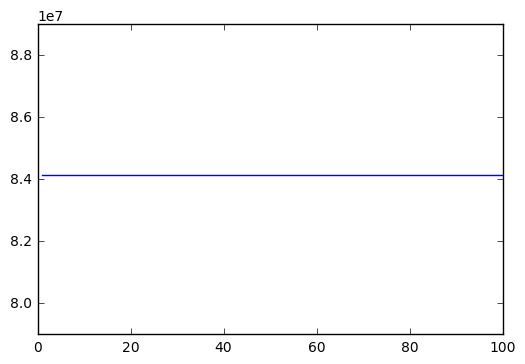

In [389]:
############## plot for initial vectors as zeros
mp.plot([t[0] for t in zero_cp],[t[1] for t in zero_cp])
mp.show()

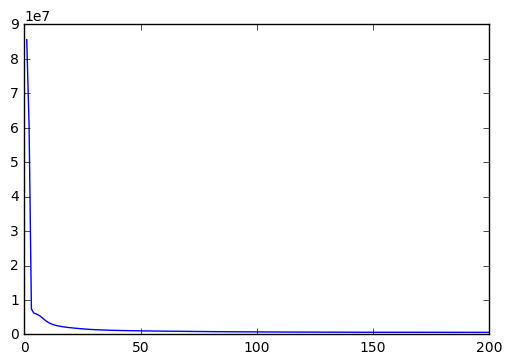

In [266]:
#plot loss as a function of iterations.... this is for vector containing random variables

import matplotlib.pyplot as mp
mp.plot([t[0] for t in cp],[t[1] for t in cp])
mp.show()

<b>1.3 Movie Similarity calculation </b>

In [270]:
##################### READ MOVIE ID - MOVIE NAME MAPPING TO A LIST FOR RECOMMENDTION #######################
f1 = open('movies.csv')
csv_f1 = csv.reader(f1,delimiter='|')

parsed1 = (
           (int(row[0]),
           row[1].split(' (')[0])
          for row in csv_f1)

movie_names = []

for row in parsed1:
    movie_names.append(row)

<b> 1.3 Movies similar to Aladdin. Have used cosine similarity here to calculate the similarity of each movie to movie Aladdin.Considered the top 10 movies with highest similarity measures for recommendation</b>

In [278]:
#get movie id for Aladdin....
mov = [id[0] for id in movie_names if id[1]=='Aladdin'][0]

In [284]:
################### using cosine similarity function from scipy package
import scipy.spatial.distance as cosd

In [303]:
################### list of similarity measures to Aladdin
Aladdin_similar = []
for i in range(1,1682):
    if(i!=mov):
        Aladdin_similar.append((i,cosd.cosine(vector_op[mov],vector_op[i])))
    

In [311]:
############################ Sort the above cosine similarity list in descending order of cosine similarity
def getKey(item):
    return item[1]
Aladdin_similar_sorted = sorted(Aladdin_similar,key=getKey,reverse=True)

In [322]:
############################### Get top 10 movies similar to Aladdin
sim_movies = [t[0] for t in Aladdin_similar_sorted[:10]]
#print(sim_movies)

[1329, 314, 1246, 1523, 1254, 1371, 1382, 1661, 1250, 1236]


In [345]:
############################### Get the names of top 10 movies similar to Aladdin
for i in range(0,len(sim_movies)):
    print([m for m in movie_names if m[0]==sim_movies[i]])

[(1329, 'Low Life, The')]
[(314, '3 Ninjas: High Noon At Mega Mountain')]
[(1246, 'Bushwhacked')]
[(1523, 'Good Man in Africa, A')]
[(1254, "Gone Fishin'")]
[(1371, 'Machine, The')]
[(1382, 'Bonheur, Le')]
[(1661, 'New Age, The')]
[(1250, 'Best of the Best 3: No Turning Back')]
[(1236, 'Other Voices, Other Rooms')]


<p><b>1.4 Movies recommended given both Home Alone and Toy Story. The recommendation strategy followed is as follows:
<li><ul> Get the top ten movies for each of Home Alone and Toy Story using cosine Similarity measure
<ul> Get similarity measure for each of Toy Story's top ten movies with Home Alone
<ul> Get similarity measure for each of Home Alone's top ten movies with Toy Story
<ul> append the above two similarity measures and get the top ten. Recommend these movies.

In [346]:
############################## find movie ids for toy story and home alone

toystory = [id[0] for id in movie_names if id[1]=='Toy Story'][0]
homealone = [id[0] for id in movie_names if id[1]=='Home Alone'][0]

In [352]:
########################## Get similarity measures of all movies with Toy Story and Home Alone
toystory_similar = []
homealone_similar = []
for i in range(1,1682):
    if(i!=toystory):
        toystory_similar.append((i,cosd.cosine(vector_op[toystory],vector_op[i])))

for i in range(1,1682):
    if(i!=homealone):
        homealone_similar.append((i,cosd.cosine(vector_op[homealone],vector_op[i])))

        

In [353]:
##########################3 sort toy story and home alone
toystory_similar_sorted = sorted(toystory_similar,key=getKey,reverse=True)
homealone_similar_sorted = sorted(homealone_similar,key=getKey,reverse=True)

# get the top ten for each movie
sim_movies_toystory = [t[0] for t in toystory_similar_sorted[:10]]
sim_movies_homealone = [t[0] for t in homealone_similar_sorted[:10]]

print(sim_movies_toystory)
print(sim_movies_homealone)

[1679, 1461, 1569, 1586, 1681, 1553, 1246, 1380, 1673, 1551]
[912, 1461, 852, 598, 1106, 1528, 1437, 677, 1270, 1622]


In [376]:
################################# calculate cross similarities between both sets. 
#################################Toy Story with movies recommended for home alone and vice versa.

sim_to_homealoneRec = []
for i in sim_movies_homealone:
    sim_to_homealoneRec.append((i,cosd.cosine(vector_op[toystory],vector_op[i])))
    
sim_to_toystoryrec = []
for i in sim_movies_toystory:
    sim_to_toystoryrec.append((i,cosd.cosine(vector_op[homealone],vector_op[i])))
    

In [377]:
##################### Sort
sorted_homealone_f = sorted(sim_to_homealoneRec,key = getKey,reverse=True)
sorted_toystory_f = sorted(sim_to_toystoryrec,key = getKey,reverse=True)

In [380]:
top_ten = []
top_ten.append([t[0] for t in sorted_homealone_f[:6]])
top_ten.append([t[0] for t in sorted_toystory_f[:6]])

In [381]:
top_ten

[[1461, 1270, 1528, 677, 1437, 852], [1461, 1586, 1569, 1673, 1246, 1553]]

In [382]:
top_t = top_ten[0]+top_ten[1]

In [394]:
#################### Top ten recommendations for Home Alone and Toy Story
for i in range(0,len(top_t)):
    print([m for m in movie_names if m[0]==top_t[i]])

[(1461, 'Here Comes Cookie')]
[(1270, 'Life with Mikey')]
[(1528, 'Nowhere')]
[(677, 'Fire on the Mountain')]
[(1437, 'House Party 3')]
[(852, 'Bloody Child, The')]
[(1461, 'Here Comes Cookie')]
[(1586, 'Lashou shentan')]
[(1569, 'Vie est belle, La')]
[(1673, 'Mirage')]
[(1246, 'Bushwhacked')]
[(1553, 'Underneath, The')]
